# This notebook explores the use of traditional machine learning to combat driver drowsiness

- Uses dlib for facial landmark detection
- Trains XGBoost on facial landmarks


## Imports


In [3]:
import os
import sys
import numpy as np
import shutil
import re
import cv2
import dlib
import pandas as pd
import xgboost as xgb
import shap
import datetime
import bz2
import matplotlib.pyplot as plt
import matplotlib
import urllib.request
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from joblib import dump
from loguru import logger
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Saving Timestamps and setting up logger

I use loguru throughout my project as its easier to configure and provides more readable and UI friendly logging


In [4]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

logger.remove()
logger.add(
    "../logs/drowsiness_{time}.log",
    rotation="500 MB",
    level="INFO",
    format="{time:YYYY-MM-DD HH:mm:ss} | {level: <8} | {message}",
    backtrace=True,
    diagnose=True,
)
logger.add(sys.stderr, level="INFO")

2

## Calculating specific facial features for the model to focus on using landmars

Utilising the landmarks to recognise speciific features research has indicated infers drowsiness


In [5]:
def calculate_eye_aspect_ratio(eye_points):
    a = distance.euclidean(eye_points[1], eye_points[5])
    b = distance.euclidean(eye_points[2], eye_points[4])
    c = distance.euclidean(eye_points[0], eye_points[3])
    return 0 if c == 0 else (a + b) / (2.0 * c)


def calculate_mouth_aspect_ratio(mouth_points):
    a = distance.euclidean(mouth_points[2], mouth_points[10])
    b = distance.euclidean(mouth_points[3], mouth_points[9])
    c = distance.euclidean(mouth_points[4], mouth_points[8])
    d = distance.euclidean(mouth_points[0], mouth_points[6])
    return 0 if d == 0 else (a + b + c) / (3.0 * d)


def detect_landmarks(
    image_path,
    predictor_path="../inputs/utils/shape_predictor_68_face_landmarks.dat",
    save_visualization=False,
    output_path=None,
):
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"Could not load image {image_path}")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    faces = detector(gray, 1)
    if not faces:
        logger.warning(f"No faces found in {image_path}")
        return None
    landmarks = predictor(gray, faces[0])
    points = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(68)])
    features = {}
    face_width = distance.euclidean(points[0], points[16])
    left_ear = calculate_eye_aspect_ratio(points[36:42])
    right_ear = calculate_eye_aspect_ratio(points[42:48])
    avg_ear = (left_ear + right_ear) / 2.0
    features.update(
        {
            "left_ear": left_ear,
            "right_ear": right_ear,
            "avg_ear": avg_ear,
            "ear_diff": abs(left_ear - right_ear),
        }
    )
    mar = calculate_mouth_aspect_ratio(points[48:68])
    features["mar"] = mar
    nose_tip, chin = points[30], points[8]
    features["head_pitch"] = distance.euclidean(nose_tip, chin) / face_width
    left_dist = distance.euclidean(points[0], points[27])
    right_dist = distance.euclidean(points[16], points[27])
    features["head_yaw"] = abs(left_dist - right_dist) / face_width
    features["emr"] = avg_ear / (mar + 0.01)
    for i in range(68):
        features[f"landmark_{2 * i}"] = landmarks.part(i).x
        features[f"landmark_{2 * i + 1}"] = landmarks.part(i).y
        if save_visualization:
            cv2.circle(
                image, (landmarks.part(i).x, landmarks.part(i).y), 2, (0, 255, 0), -1
            )
    if save_visualization and output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, image)
    return features

## Downloading Landmark Predictor from dlib

This code will skip this step if it has already been installed


In [6]:
def download_predictor(
    dest_path="../inputs/utils/shape_predictor_68_face_landmarks.dat",
):
    if not os.path.exists(dest_path):
        logger.info("Downloading predictor...")
        bz2_file = dest_path + ".bz2"
        urllib.request.urlretrieve(
            "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2", bz2_file
        )
        with bz2.BZ2File(bz2_file) as f_in, open(dest_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
        os.remove(bz2_file)
        logger.success(f"Saved predictor to {dest_path}")
    else:
        logger.info(f"Predictor already at {dest_path}")


download_predictor()

2025-05-09 06:38:07.556 | INFO     | __main__:download_predictor:15 - Predictor already at ../inputs/utils/shape_predictor_68_face_landmarks.dat


## Create Focused Landmarks Dataset

We store features as a csv for the model to ingest


In [7]:
def create_landmarks_dataset(
    data_dirs,
    output_csv,
    predictor_path="../inputs/utils/shape_predictor_68_face_landmarks.dat",
    vis_dir=None,
):
    all_data = []
    for cls, d in data_dirs.items():
        for img in os.listdir(d):
            if not img.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            features = detect_landmarks(
                os.path.join(d, img),
                predictor_path,
                save_visualization=bool(vis_dir),
                output_path=(os.path.join(vis_dir, cls, img) if vis_dir else None),
            )
            if features:
                features.update({"image": img, "class": 1 if cls == "drowsy" else 0})
                match = re.search(r"([A-Za-z]{1,2})(\d+)", img)
                features["person_id"] = match.group(1).upper() if match else "unknown"
                all_data.append(features)
    df = pd.DataFrame(all_data)
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df.to_csv(output_csv, index=False)
    return df


data_dirs = {
    "drowsy": "../inputs/datasets/raw/drowsy/",
    "non_drowsy": "../inputs/datasets/raw/non_drowsy/",
}
landmarks_csv = "../inputs/utils/advanced_landmarks.csv"
if os.path.exists(landmarks_csv):
    landmarks_df = pd.read_csv(landmarks_csv)
else:
    landmarks_df = create_landmarks_dataset(
        data_dirs, landmarks_csv, vis_dir="../outputs/visuals"
    )

## Splitting by person and training a focused XG Boost Model

We split the data by person as I found that the model was actually starting to recognise who was drowsy and who wasn't drowsy based on who each person actually was, so to improve accuracy, I split the training, validation and test sets into separate people to help improve the models performance on unseen data.


In [8]:
def split_by_person(df, train=0.7, val=0.15, test=0.15, seed=115086):
    ids = df["person_id"].unique()
    np.random.seed(seed)
    np.random.shuffle(ids)
    n = len(ids)
    train_ids = ids[: int(train * n)]
    val_ids = ids[int(train * n) : int((train + val) * n)]
    test_ids = ids[int((train + val) * n) :]
    return (
        df[df.person_id.isin(train_ids)],
        df[df.person_id.isin(val_ids)],
        df[df.person_id.isin(test_ids)],
    )


train_df, val_df, test_df = split_by_person(landmarks_df)
features = [
    "right_ear",
    "avg_ear",
    "mar",
    "emr",
    "head_yaw",
    "head_pitch",
    "left_ear",
    "ear_diff",
]
X_train, y_train = train_df[features], train_df["class"]
X_val, y_val = val_df[features], val_df["class"]
X_test, y_test = test_df[features], test_df["class"]
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
logger.info("Training focused XGBoost model on top features")
focused_model = xgb.XGBClassifier(
    learning_rate=0.1, max_depth=5, n_estimators=1000, random_state=1105086
)
focused_model.fit(X_train_s, y_train)
val_acc = focused_model.score(X_val_s, y_val)
logger.info(f"Validation accuracy: {val_acc:.4f}")
probs = focused_model.predict_proba(X_val_s)[:, 1]
best_f1, best_thresh = 0, 0.5
for t in np.arange(0.5, 0.9, 0.05):
    f1 = f1_score(y_val, (probs >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
logger.info(f"Best thresh: {best_thresh:.2f} (F1={best_f1:.4f})")
probs_test = focused_model.predict_proba(X_test_s)[:, 1]
pred_test = (probs_test >= best_thresh).astype(int)
logger.info(f"Classification Report:\n{classification_report(y_test, pred_test)}")
logger.info(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_test)}")
os.makedirs("../outputs/models", exist_ok=True)
dump(focused_model, "../outputs/models/xgboost/focused_xgb_model.joblib")
dump(scaler, "../outputs/models/xgboost/focused_scaler.joblib")
with open("../outputs/models/xgboost/focused_threshold.txt", "w") as f:
    f.write(str(best_thresh))
with open("../outputs/models/xgboost/focused_features.txt", "w") as f:
    f.write("\n".join(features))
logger.success("Focused XGBoost model saved successfully")

2025-05-09 06:38:07.590 | INFO     | __main__:<module>:34 - Training focused XGBoost model on top features
2025-05-09 06:38:08.604 | INFO     | __main__:<module>:40 - Validation accuracy: 0.5976
2025-05-09 06:38:08.634 | INFO     | __main__:<module>:47 - Best thresh: 0.50 (F1=0.5541)
2025-05-09 06:38:08.642 | INFO     | __main__:<module>:50 - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.81       159
           1       0.67      0.81      0.73        98

    accuracy                           0.77       257
   macro avg       0.77      0.78      0.77       257
weighted avg       0.79      0.77      0.78       257

2025-05-09 06:38:08.643 | INFO     | __main__:<module>:51 - Confusion Matrix:
[[120  39]
 [ 19  79]]
2025-05-09 06:38:08.653 | SUCCESS  | __main__:<module>:59 - Focused XGBoost model saved successfully


## Producing non stacking confusion matrix

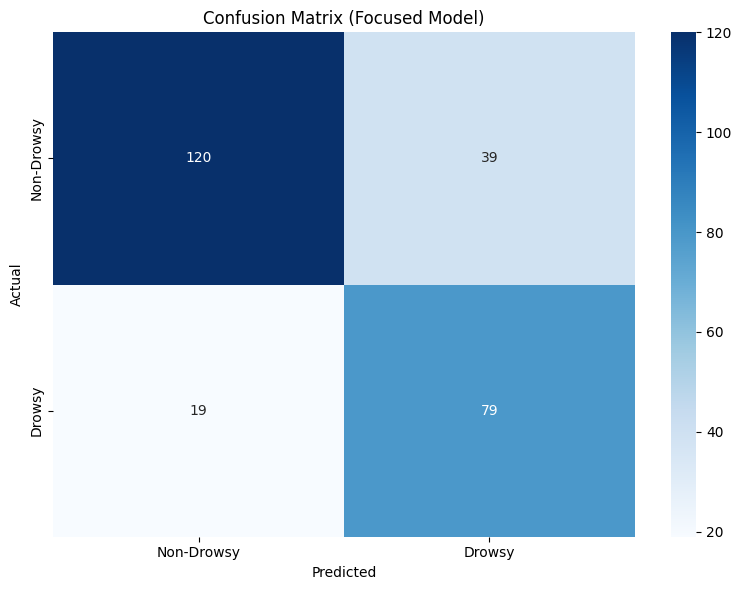

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
cm_focused = confusion_matrix(y_test, (focused_model.predict_proba(X_test_s)[:, 1] >= best_thresh).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_focused, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Drowsy", "Drowsy"], yticklabels=["Non-Drowsy", "Drowsy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Focused Model)")
plt.tight_layout()
plt.savefig("../outputs/visuals/xgboost/confusion_matrix_focused.png")
plt.show()

## Training a Stacking Ensemble


In [ ]:
logger.info("Setting up stacking ensemble: XGB, LGBM, RF → LR")

base_learners = [
    (
        "xgb",
        xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            learning_rate=0.1,
            max_depth=5,
            n_estimators=1000,
            random_state=1105086,
        ),
    ),
    ("lgb", LGBMClassifier()),
    ("rf", RandomForestClassifier()),
]
meta_learner = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=False, 
    n_jobs=-1,
)

stacking_model.fit(X_train_s, y_train)
val_acc = stacking_model.score(X_val_s, y_val)
logger.info(f"Stacking validation accuracy: {val_acc:.4f}")


probs_val = stacking_model.predict_proba(X_val_s)[:, 1]
best_f1, best_thresh = 0, 0.5
for t in np.arange(0.5, 0.9, 0.05):
    f1 = f1_score(y_val, (probs_val >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
logger.info(f"Stacking best threshold: {best_thresh:.2f} (F1={best_f1:.4f})")


probs_test = stacking_model.predict_proba(X_test_s)[:, 1]
pred_test = (probs_test >= best_thresh).astype(int)
logger.info(
    "Stacking Classification Report:\n" + classification_report(y_test, pred_test)
)
logger.info("Stacking Confusion Matrix:\n" + str(confusion_matrix(y_test, pred_test)))


os.makedirs("../outputs/models", exist_ok=True)
dump(stacking_model, "../outputs/models/xgboost/stacking_model.joblib")
logger.success("Stacking ensemble saved successfully")

2025-05-09 06:38:08.658 | INFO     | __main__:<module>:1 - Setting up stacking ensemble: XGB, LGBM, RF → LR
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 677, number of negative: 618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1295, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522780 -> initscore=0.091183
[LightGBM] [Info] Start training from score 0.091183


[06:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[06:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[06:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[06:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[06:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 542, number of negative: 494
[LightGBM] [Info] Number of positive: 541, number of negative: 495
[LightGBM] [Info] Number of positive: 542, number of negative: 494
[LightGBM] [Info] Number of positive: 542, number of negative: 494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1036, number of used features: 8
[LightGBM] [Info] Number of data points in the train set: 1036, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhe

/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/v

## Feature Importance Comparison Across Models


2025-05-09 06:41:29.639 | INFO     | __main__:<module>:10 - Extracting feature importances for XGBoost
2025-05-09 06:41:29.642 | INFO     | __main__:<module>:10 - Extracting feature importances for LightGBM
2025-05-09 06:41:29.648 | INFO     | __main__:<module>:10 - Extracting feature importances for RandomForest


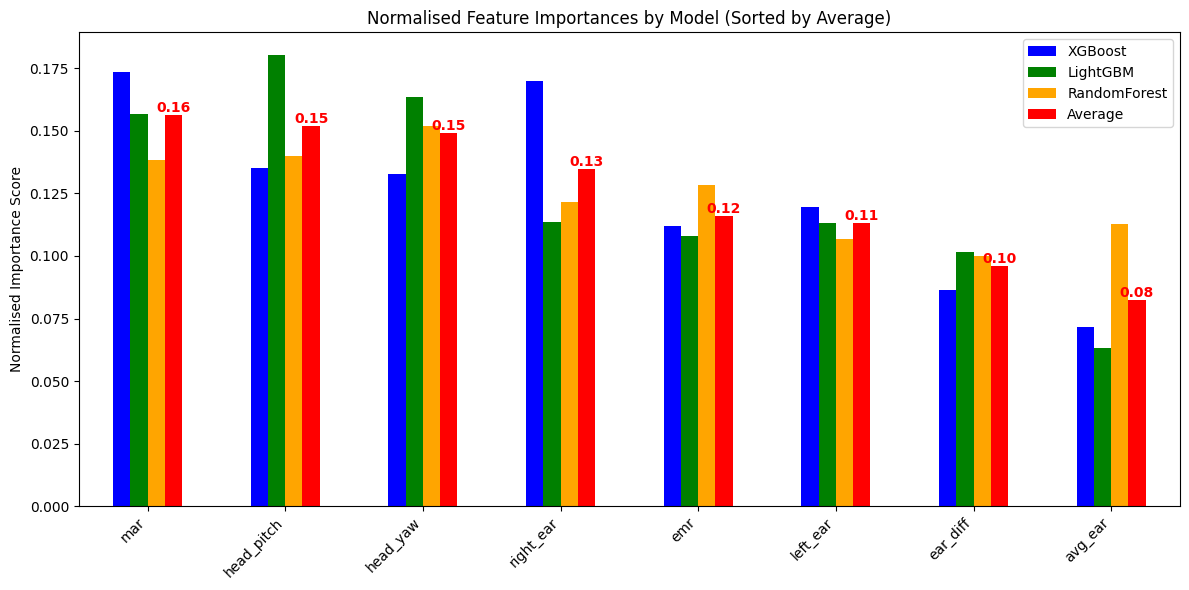

In [17]:
models = {
    "XGBoost": stacking_model.named_estimators_["xgb"],
    "LightGBM": stacking_model.named_estimators_["lgb"],
    "RandomForest": stacking_model.named_estimators_["rf"],
}

importances = {}
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        logger.info(f"Extracting feature importances for {name}")
        importances[name] = model.feature_importances_
    elif hasattr(model, "coef_"):
        logger.info(f"Extracting coefficients for {name}")
        importances[name] = model.coef_[0]

df_importances = pd.DataFrame(importances, index=features)

df_norm = df_importances.copy()
for col in df_norm.columns:
    df_norm[col] = df_norm[col] / df_norm[col].sum()

df_norm["Average"] = df_norm.mean(axis=1)

df_norm = df_norm.sort_values("Average", ascending=False)
colors = ["blue", "green", "orange", "red"]

ax = df_norm.plot(kind="bar", figsize=(12, 6), title="Normalised Feature Importances by Model (Sorted by Average)", color=colors)
plt.ylabel("Normalised Importance Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

for rect in ax.containers[-1]:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        color="red",
        fontweight="bold",
    )

plt.savefig("../outputs/visuals/xgboost/normalized_feature_importance_comparison.png")
plt.show()

## ROC Curve Comparison for All Models


/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


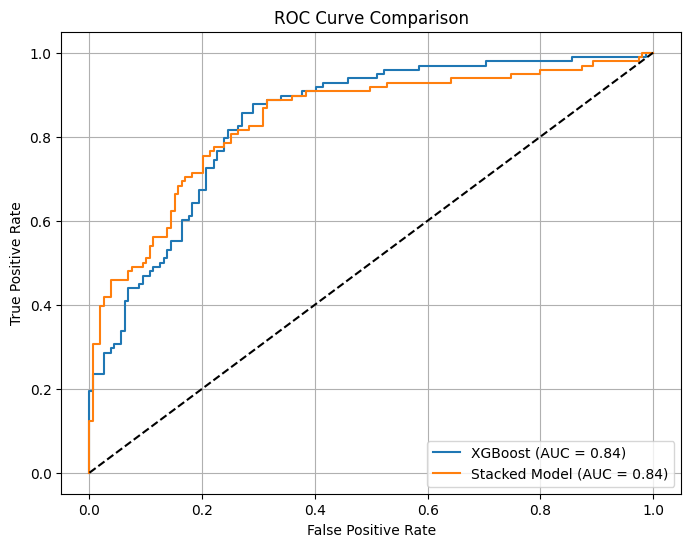

In [11]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# focused XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, focused_model.predict_proba(X_test_s)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.2f})")

# ensemble
fpr_stack, tpr_stack, _ = roc_curve(
    y_test, stacking_model.predict_proba(X_test_s)[:, 1]
)
plt.plot(
    fpr_stack, tpr_stack, label=f"Stacked Model (AUC = {auc(fpr_stack, tpr_stack):.2f})"
)

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("../outputs/visuals/xgboost/roc_comparison.png")
plt.show()

## Calibration Curve


/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


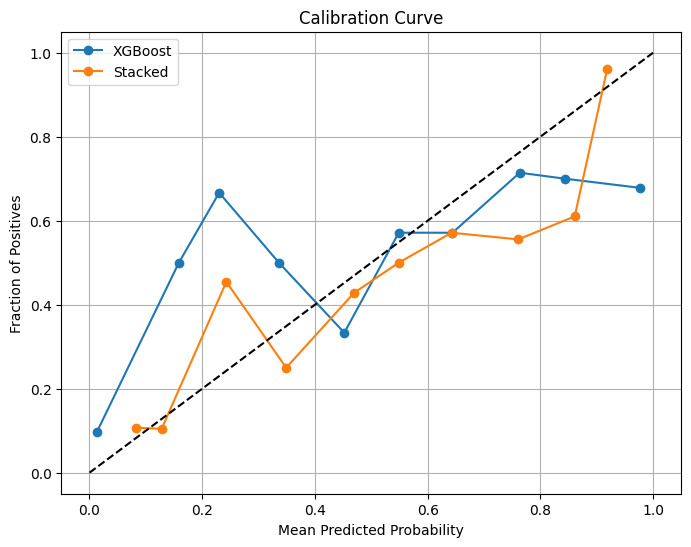

In [12]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))

for name, model in [("XGBoost", focused_model), ("Stacked", stacking_model)]:
    prob_pos = model.predict_proba(X_test_s)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker="o", label=name)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.savefig("../outputs/visuals/xgboost/calibration_curve.png")
plt.show()

## Comparison Table


In [13]:
from sklearn.metrics import roc_auc_score

summary = pd.DataFrame(
    {
        "Model": ["Focused XGBoost", "Stacked Ensemble"],
        "Accuracy": [
            accuracy_score(
                y_test,
                (focused_model.predict_proba(X_test_s)[:, 1] >= best_thresh).astype(
                    int
                ),
            ),
            accuracy_score(
                y_test,
                (stacking_model.predict_proba(X_test_s)[:, 1] >= best_thresh).astype(
                    int
                ),
            ),
        ],
        "F1 Score": [
            f1_score(
                y_test,
                (focused_model.predict_proba(X_test_s)[:, 1] >= best_thresh).astype(
                    int
                ),
            ),
            f1_score(
                y_test,
                (stacking_model.predict_proba(X_test_s)[:, 1] >= best_thresh).astype(
                    int
                ),
            ),
        ],
        "ROC AUC": [
            roc_auc_score(y_test, focused_model.predict_proba(X_test_s)[:, 1]),
            roc_auc_score(y_test, stacking_model.predict_proba(X_test_s)[:, 1]),
        ],
    }
)

print(summary)
os.makedirs("../csvs/xgbooststacked", exist_ok=True)
summary.to_csv("../csvs/xgbooststacked/model_comparison.csv", index=False)


              Model  Accuracy  F1 Score   ROC AUC
0   Focused XGBoost  0.774319  0.731481  0.839173
1  Stacked Ensemble  0.774319  0.723810  0.838788


/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Per Person Performance


/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/92/nm406v_n469bj530yd0ng5l40000gn/T/ipykernel_62379/1476936526.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: f1_score(x["y_true"], x["y_pred"]))


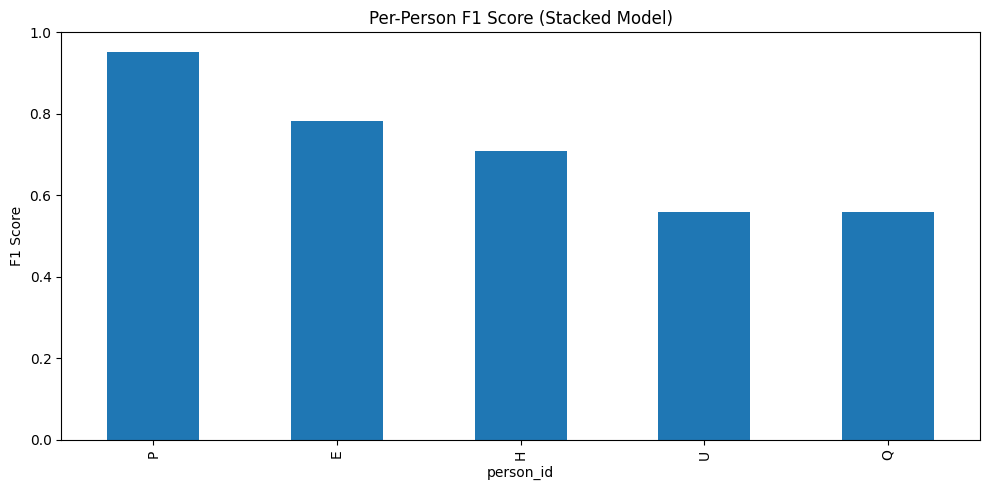

In [ ]:
test_df = test_df.copy()
test_df["y_true"] = y_test
test_df["y_pred"] = (
    stacking_model.predict_proba(X_test_s)[:, 1] >= best_thresh
).astype(int)

person_scores = (
    test_df.groupby("person_id")
    .apply(lambda x: f1_score(x["y_true"], x["y_pred"]))
    .sort_values(ascending=False)
)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
person_scores.plot(kind="bar")
plt.title("Per-Person F1 Score (Stacked Model)")
plt.ylabel("F1 Score")
plt.tight_layout()
os.makedirs("../outputs/visuals", exist_ok=True)
plt.savefig("../outputs/visuals/xgboost/per_person_f1_score.png")
plt.show()

## SHAP Interpretability for the XGBoost Base Learner


/var/folders/92/nm406v_n469bj530yd0ng5l40000gn/T/ipykernel_62379/2468923925.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_s, feature_names=features, show=False)


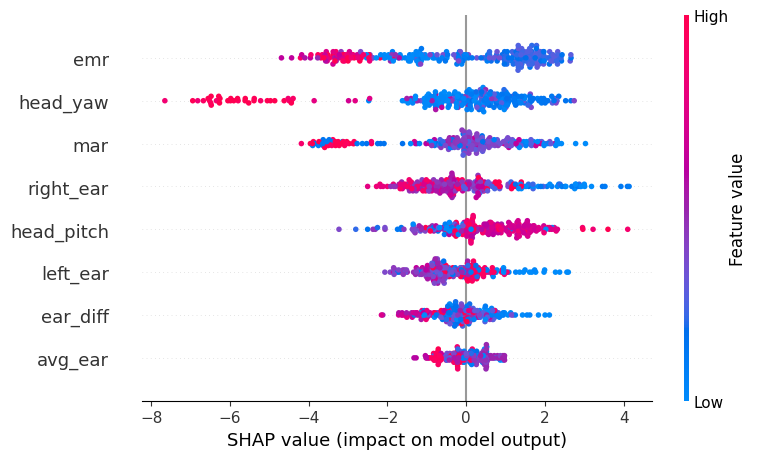

In [ ]:
xgb_base = stacking_model.named_estimators_["xgb"]

explainer = shap.Explainer(xgb_base)
shap_values = explainer(X_test_s)


shap.summary_plot(shap_values, X_test_s, feature_names=features, show=False)

## Produce confusion matrix plot

/Users/tobylowe/drowsiness detection final/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


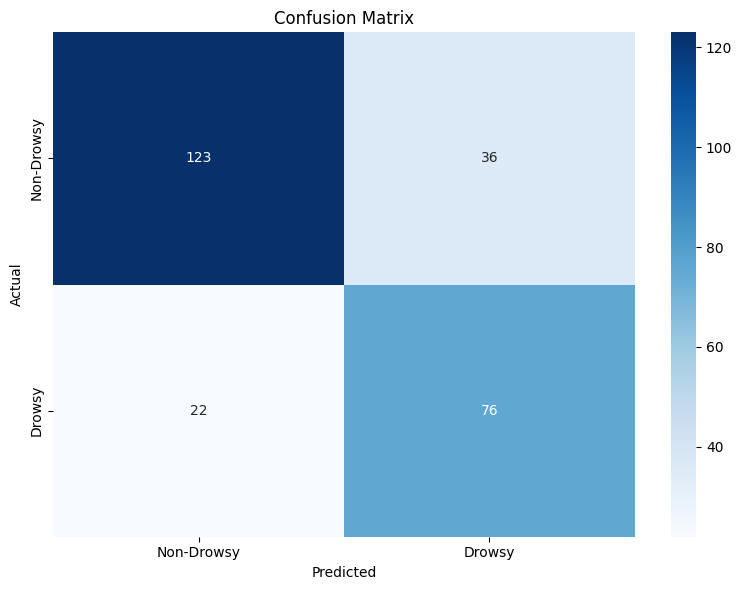

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

if 'y_test' not in globals():
	raise NameError("y_test is not defined. Ensure CELL INDEX 12 is executed before running this cell.")

cm = confusion_matrix(y_test, (stacking_model.predict_proba(X_test_s)[:, 1] >= best_thresh).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Drowsy", "Drowsy"], yticklabels=["Non-Drowsy", "Drowsy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../outputs/visuals/xgboost/confusion_matrix.png")
plt.show()